In [1]:
%load_ext autoreload 
%autoreload 2

import os
import random
from collections import deque
import numpy as np
import scipy.linalg as sl
from PIL import Image, ImageDraw
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from IPython import display

import torch
from torch import nn, distributions as dist, autograd
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, CenterCrop, RandomHorizontalFlip, RandomVerticalFlip, ToTensor, Normalize
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.set_default_dtype(torch.float32)
plt.style.use('seaborn-v0_8')

from emnist_letters import EMNISTLettersTrain, EMNISTLettersTest

/env_dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_size = 28
batch_size = 512
num_classes = 32
zdim = 50

In [3]:
train_ds = EMNISTLettersTrain(transform=Compose([
    ToTensor(),
    # RandomHorizontalFlip(0.1),
    # RandomVerticalFlip(0.1),
    Normalize(127., 128.0)
]))
val_ds = EMNISTLettersTest(transform=Compose([
    ToTensor(),
    Normalize(127., 128.0)
]))


In [4]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, drop_last=True)

In [5]:
class Upsample(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size=3, 
                stride=2, padding=0, outpout_padding=0):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, 
                                       out_channels, 
                                       kernel_size=kernel_size, 
                                       stride=stride, 
                                       padding=padding,
                                       output_padding=outpout_padding
                                       )
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x

class Generator(nn.Module):
    
    def __init__(self, zdim=64):
        super().__init__()
        self.label_embedding = nn.Embedding(num_classes, 128)
        self.ln = nn.LayerNorm(128)
        self.emb_dense = nn.Linear(128, zdim)
        
        with torch.no_grad():
            nn.init.normal_(self.emb_dense.weight, -0.005, 0.005)
            nn.init.zeros_(self.emb_dense.bias)

        self.dense = nn.Linear(2*zdim, 7*7*128)
        self.act1 = nn.LeakyReLU()
        
        self.upsample2 = Upsample(128, 64, kernel_size=3, padding=1, stride=1)
        self.upsample3 = Upsample(64, 32, kernel_size=3, padding=1, stride=2, outpout_padding=1)
        self.upsample4 =nn.ConvTranspose2d(32, 
                                       1, 
                                       kernel_size=3, 
                                       stride=2, 
                                       padding=1,
                                       output_padding=1
                                       )
        self.normalizer = nn.Tanh()
        
    def forward(self, z, y):
        y = y.unsqueeze(1)
        yemb = self.label_embedding(y)
        yemb = self.ln(yemb) / np.sqrt(self.label_embedding.embedding_dim)
        yfeat = self.emb_dense(yemb)
        yfeat = F.leaky_relu(yfeat)
        
        z = torch.cat([z, yfeat.squeeze(1)], dim=1)
        
        x = self.dense(z)
        x = self.act1(x)
        x = x.view((x.size(0), 128, 7, 7,))
        x = self.upsample2(x)
        x = self.upsample3(x)
        x = self.upsample4(x)
        x = self.normalizer(x)
        return x


class Discriminator(nn.Module):
    
    def __init__(self, eps=1e-5):
        super().__init__()
        self.label_embedding = nn.Embedding(num_classes, 128)
        self.ln = nn.LayerNorm(128)
        self.emb_dense = nn.Linear(128, 28*28)
        
        with torch.no_grad():
            nn.init.normal_(self.emb_dense.weight, -0.005, 0.005)
            nn.init.zeros_(self.emb_dense.bias)
        
        self.net = nn.Sequential(
            nn.Conv2d(2, 32, 3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Conv2d(64, 32, 3, stride=2, padding=1),
        
        )

        self.dense = nn.Sequential(
            nn.Linear( 1568, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        
            
        self.img_class = nn.Linear(128, 1)
        self.label_class = nn.Linear(128, num_classes)
        self.eps = eps
        
    def forward(self, x, y):
        _y = y.unsqueeze(1)
        yemb = self.label_embedding(_y)
        yemb = self.ln(yemb) / np.sqrt(self.label_embedding.embedding_dim)
        yfeat = self.emb_dense(yemb)
        yfeat = F.tanh(yfeat)
        
        # print(x.size(), yfeat.size(), yfeat.view((yfeat.size(0),) + tuple(x.shape[1:])).size())
        x = torch.cat([x, yfeat.view((yfeat.size(0),) + tuple(x.shape[1:]))], 1)
        x = self.net(x)
        x = x.view((x.size(0), -1))
        x = self.dense(x)
        
        gen_class = self.img_class(x)
        label_class = self.label_class(x)
        
        return gen_class, label_class
    
# Generator()(torch.randn((2, 64)), torch.randint(0, num_classes, (2, ))).size()
# Discriminator()(torch.randn((2, 1, 28, 28)), torch.randint(0, num_classes, (2, )))[1].size()

In [6]:
class CGanTrainer:
    
    def __init__(self, 
                 train_loader, 
                 val_loader=None, 
                 epochs=0,
                 zdim=50, 
                 dsteps=10,
                 savepath=None, 
                 batch_size=1,
                 eval_epoch=1000000,
                 device=torch.device("cuda")
                 ):
        self.gmodel = Generator(zdim)
        self.dmodel = Discriminator()
        if device.type == "cuda":
            self.gmodel.cuda()
            self.dmodel.cuda()
            
        self.train_loader = train_loader
        self.val_loader = val_loader
        
        self.epochs = epochs
        self.batch_size = batch_size
        self.eval_epoch = eval_epoch
        self.dsteps = dsteps
        self.zdim = zdim
        self.device = device
        self.n_samples = 0
        
        self.doptimizer = torch.optim.Adam(self.dmodel.parameters(), lr=1e-5)    
        self.goptimizer = torch.optim.Adam(self.gmodel.parameters(), lr=1e-4)  
        
        self.noise_sampler = dist.Normal(0., 1.)
        self.test_images_z = self.noise_sampler.sample((64, zdim)).to(self.device).detach()
        self.test_images_y = torch.randint(0, num_classes, (64, )).to(self.device)
        self.savepath = savepath
        if self.savepath is not None:
            os.makedirs(self.savepath, exist_ok=True)
        
    def fit(self, epoch, loader):
        losses = {"generator": [], "discriminator": []}
        self.gmodel.train()
        self.dmodel.train()
        for step, (imgs, cls_label) in enumerate(loader):
            cls_label = cls_label.to(self.device)
            gen_is_training = step > 0 and step % self.dsteps == 0
            noise_z = self.get_noise_sample()
            
            fake_imgs = self.gmodel(noise_z, cls_label)
            
            
            real_imgs = imgs.to(self.device)
            
            disc_real_gen_out, disc_real_cls_out = self.dmodel(real_imgs, cls_label)
            disc_fake_gen_out, disc_fake_cls_out = self.dmodel(fake_imgs, cls_label)
            
            real_labels = disc_real_gen_out.new_ones((disc_real_gen_out.size(0), 1))
            fake_labels = disc_fake_gen_out.new_zeros((disc_fake_gen_out.size(0), 1))
            
            disc_loss = (
                F.binary_cross_entropy_with_logits(disc_real_gen_out, real_labels) +
                F.binary_cross_entropy_with_logits(disc_fake_gen_out, fake_labels) + 
                F.cross_entropy(disc_real_cls_out, cls_label) 
                # F.cross_entropy(disc_fake_cls_out, cls_label) 
                
            )
            self.doptimizer.zero_grad()
            self.goptimizer.zero_grad()
            disc_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.dmodel.parameters(), 1.)
            self.doptimizer.step()
            
            self.doptimizer.zero_grad()
            self.goptimizer.zero_grad()
            losses["discriminator"].append(float(disc_loss))
            
            if gen_is_training:
                noise_z = self.get_noise_sample()
                fake_imgs = self.gmodel(noise_z, cls_label)
                disc_fake_gen_out, disc_fake_cls_out = self.dmodel(fake_imgs, cls_label)
                gen_loss =  (
                    F.binary_cross_entropy_with_logits(disc_fake_gen_out, real_labels) + 
                    F.cross_entropy(disc_fake_cls_out, cls_label) 
                )
                gen_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.gmodel.parameters(), 1.)

                self.goptimizer.step()
                losses["generator"].append(float(gen_loss))
                
            
            if step % 30 == 0:
                print(f"Epoch: {epoch}, step: {step}, dloss: {np.mean(losses['discriminator'])}, gloss: {np.mean(losses['generator'])}")
                self.generate_imgs()
        return losses
    
    def get_noise_sample(self, sample_size=-1):
        if sample_size == -1:
            sample_size = self.batch_size
        zsamples = self.noise_sampler.sample((sample_size, self.zdim)).to(self.device)
        return zsamples
        
    def train(self):
        self.train_losses = {"generator": [], "discriminator": []}
        for epoch in range(1, self.epochs + 1):
            losses = self.fit(epoch, train_loader)
            self.train_losses["discriminator"].extend(losses["discriminator"])
            self.train_losses["generator"].extend(losses["generator"])
            if epoch % self.eval_epoch == 0:
                # self.evaluate(epoch)
                self.generate_imgs( )
        self.generate_imgs()
        return 
    
    def generate_imgs(self):
        savepath = os.path.join(self.savepath, f"samples{self.n_samples}")
        os.makedirs(savepath, exist_ok=True)
        nsample = self.test_images_z.size(0)
        self.gmodel.eval()
        with torch.no_grad():
            xgen = self.gmodel(self.test_images_z, self.test_images_y)
            
            imgs = xgen.permute((0, 2, 3, 1))
            imgs = imgs.squeeze(-1)
            
            imgs *= 128.
            imgs += 127.
            
            imgs = list(imgs.unbind())
            for n in range(nsample):
                fname = os.path.join(savepath, f"img{n}.jpeg")
                imgs[n] = imgs[n].detach().cpu().long().numpy().astype(np.uint8)
                
                self.save_img(imgs[n], fname, int(self.test_images_y[n].item()))
        self.gmodel.train()

        self.n_samples += 1
    
    def save_img(self, imgs, fname, label):
        pil_img = Image.fromarray(imgs, mode="L").resize((128, 128))
        draw_img = ImageDraw.ImageDraw(pil_img, )
        
        draw_img.text((100, 100), f"{label: 03d}", )
        
        pil_img.save(fname)

In [7]:
trainer = CGanTrainer(
                 train_loader, 
                 val_loader=val_loader, 
                 zdim=64, 
                 dsteps=2,
                 savepath="/mnt/dl/generation/cgan", 
                 batch_size=batch_size,
                 device=torch.device("cuda"),
                 epochs=1000,
                 eval_epoch=1,
                 
                 )

In [8]:
trainer.train()

/env_dl/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/env_dl/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 1, step: 0, dloss: 4.895976543426514, gloss: nan


Epoch: 1, step: 30, dloss: 4.861710779128536, gloss: 4.181219514211019
Epoch: 1, step: 60, dloss: 4.82336383569436, gloss: 4.189550971984863
Epoch: 1, step: 90, dloss: 4.793497745807354, gloss: 4.189511765374077
Epoch: 1, step: 120, dloss: 4.759806967963857, gloss: 4.192222142219544
Epoch: 1, step: 150, dloss: 4.726999058628714, gloss: 4.194541110992431
Epoch: 1, step: 180, dloss: 4.699122183889315, gloss: 4.198255629009671
Epoch: 1, step: 210, dloss: 4.666421325285853, gloss: 4.214348584129697
Epoch: 1, step: 240, dloss: 4.6313480856013, gloss: 4.231561589241028
Epoch: 2, step: 0, dloss: 4.332942008972168, gloss: nan
Epoch: 2, step: 30, dloss: 4.273146921588529, gloss: 4.4126513481140135
Epoch: 2, step: 60, dloss: 4.239185223813917, gloss: 4.417901357014974
Epoch: 2, step: 90, dloss: 4.212028770656376, gloss: 4.421445984310574
Epoch: 2, step: 120, dloss: 4.193107005978419, gloss: 4.420623389879863
Epoch: 2, step: 150, dloss: 4.187765778295252, gloss: 4.408601620992025
Epoch: 2, step: 

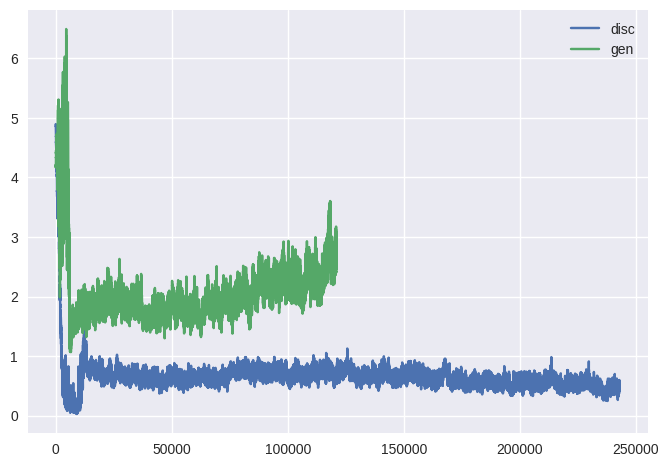

In [9]:
plt.plot(trainer.train_losses["discriminator"], label='disc')
plt.plot(trainer.train_losses["generator"], label='gen')
plt.legend()

In [10]:
nn.Conv2d(3, 5, 7, padding = 3)(torch.randn((2, 3, 32, 32))).size()

torch.Size([2, 5, 32, 32])